In [31]:
import numpy as np
import torch
#from networks import Toy_Enc_Dec
from config import Base_Enc_Dec_Cfg
from trainer import Base_Trainer

import config
from networks import Sparse_AutoEnc

from torch.utils.data import Dataset

import torchvision
import config

In [2]:
train_data = torchvision.datasets.MNIST(root='data', train=True, download=True, transform=torchvision.transforms.ToTensor())
test_data = torchvision.datasets.MNIST(root='data', train=False, download=True, transform=torchvision.transforms.ToTensor())

In [3]:
simple_enc_dec = Toy_Enc_Dec()
config = Base_Enc_Dec_Cfg()
simple_trainer = Base_Trainer(simple_enc_dec, config, train_data=train_data, test_data=test_data)

In [5]:
state_dict = torch.load('./toy_MNIST_enc_dec.pth')
simple_enc_dec.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
simple_enc_dec.eval()
with torch.no_grad():
    for x, _ in list(train_data)[:10]:
        x = x.to(config.device)
        x = simple_enc_dec.flatten(x)
        preds = simple_enc_dec(x)
        simple_enc_dec.reconstruct_im(x)
        simple_enc_dec.reconstruct_im(preds)

In [15]:
simple_enc_dec._modules.keys()

odict_keys(['flatten', 'encoder', 'decoder'])

In [17]:
type(getattr(simple_enc_dec, 'encoder'))

torch.nn.modules.container.Sequential

In [2]:
import toponets
topo_nanogpt = toponets.nanogpt(tau=50.0, checkpoint_path = "./tau_50.0.pt")
topo_nanogpt.transformer.h = topo_nanogpt.transformer.h[-1]
#adding a sparse autoenc layer


number of parameters: 123.59M


In [39]:
topo_nanogpt = toponets.nanogpt(tau=50.0, checkpoint_path = "./tau_50.0.pt")
topo_nanogpt.transformer.h[-1].mlp.c_proj

number of parameters: 123.59M


Linear(in_features=3072, out_features=768, bias=False)

In [3]:
from topoloss.cortical_sheet.output import get_cortical_sheet_linear
import matplotlib.pyplot as plt

In [16]:
topo_nanogpt.transformer.h.mlp

MLP(
  (c_fc): Linear(in_features=768, out_features=3072, bias=False)
  (gelu): GELU(approximate='none')
  (c_proj): Linear(in_features=3072, out_features=768, bias=False)
  (dropout): Dropout(p=0.0, inplace=False)
)

In [17]:
topo_nanogpt.transformer.h.mlp.c_proj

Linear(in_features=3072, out_features=768, bias=False)

In [6]:
topo_nanogpt

GPT(
  (transformer): ModuleDict(
    (wte): Embedding(50304, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.0, inplace=False)
    (h): Block(
      (ln_1): LayerNorm()
      (attn): CausalSelfAttention(
        (c_attn): Linear(in_features=768, out_features=2304, bias=False)
        (c_proj): Linear(in_features=768, out_features=768, bias=False)
        (attn_dropout): Dropout(p=0.0, inplace=False)
        (resid_dropout): Dropout(p=0.0, inplace=False)
      )
      (ln_2): LayerNorm()
      (mlp): MLP(
        (c_fc): Linear(in_features=768, out_features=3072, bias=False)
        (gelu): GELU(approximate='none')
        (c_proj): Linear(in_features=3072, out_features=768, bias=False)
        (dropout): Dropout(p=0.0, inplace=False)
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=768, out_features=50304, bias=False)
)

In [36]:
import networks

In [37]:
topo_sae_cfg = config.SAE_Cfg()
topo_sae = Sparse_AutoEnc(topo_sae_cfg, topo_nanogpt)

TypeError: Sparse_AutoEnc.__init__() takes 2 positional arguments but 3 were given

In [26]:
topo_sae.parameters

<bound method Module.parameters of Sparse_AutoEnc(
  (enc): Linear(in_features=768, out_features=6144, bias=True)
  (dec): Linear(in_features=6144, out_features=768, bias=True)
)>

In [30]:
from datasets import load_dataset

fw = load_dataset("HuggingFaceFW/fineweb", name="sample-10BT", split="train", streaming=True)

Resolving data files:   0%|          | 0/25868 [00:00<?, ?it/s]

In [66]:
train_data = torch.utils.data.DataLoader(fw, batch_size=64, shuffle=False)

In [46]:
topo_nanogpt = toponets.nanogpt(tau=50.0, checkpoint_path = "./tau_50.0.pt")

number of parameters: 123.59M


In [74]:
import tiktoken
from torch.nn.utils.rnn import pad_sequence

In [68]:
train_data = torch.utils.data.DataLoader(fw, batch_size=64, shuffle=False)

In [79]:
enc = tiktoken.get_encoding("gpt2")
for inp in train_data:
    #print('inp is', inp.keys())
    #print('specific inp is', inp['token_count'])
    #print('text of inp is', inp['text'][1])
    tokenized_ids = [enc.encode_ordinary(s) for s in inp['text']]
    print('tokenized_ids', tokenized_ids)
    # Pad sequences to the maximum length in the batch
    max_length = 512  # GPT-2's max context size
    truncated_ids = [seq[:max_length] for seq in tokenized_ids]
    
    padded_ids = pad_sequence(
        [torch.tensor(seq) for seq in truncated_ids],
        batch_first=True,      # Shape: [batch_size, max_seq_length]
        padding_value=50256    # Use GPT-2's pad token (or 0 if no pad token)
    )

    # Create attention mask (1 for real tokens, 0 for padding)
    attention_mask = (padded_ids != 50256).int()
    #print('ids is', ids)
    inp = torch.tensor(padded_ids)
    print('inp is', inp.shape)
    #inp = inp.unsqueeze(0)
    #print('inp shape', inp.shape)
    # inp = torch.tensor(inp['text'])
    # #inference w/ text?
    #out = topo_nanogpt(inp)
    #print('out is', out)
    break

tokenized_ids [[91, 7680, 278, 14206, 2947, 3574, 25, 1338, 9437, 364, 329, 262, 6119, 286, 3945, 1367, 400, 91, 198, 91, 43, 346, 15886, 15146, 352, 2211, 11, 7769, 25, 3365, 3001, 91, 198, 3987, 470, 1337, 546, 29476, 14, 51, 6321, 14, 44875, 12, 44875, 13, 2094, 470, 1337, 546, 3409, 72, 11, 1107, 11, 475, 7725, 326, 356, 651, 617, 922, 366, 49302, 1565, 4221, 32, 24700, 36, 37160, 1526, 75, 8107, 5830, 12, 1273, 3565, 503, 286, 340, 13, 843, 366, 3605, 9275, 1, 7666, 13, 4222, 13, 1002, 691, 13, 198, 2257, 25425, 1565, 46, 3228, 24483, 37, 1565, 46, 11, 24483, 37, 1565, 46, 11, 24483, 37, 1565, 46, 13896, 1058, 2395, 263, 25, 198, 91, 4561, 9437, 364, 329, 262, 6119, 286, 3945, 1367, 400, 14128, 24644, 50, 25, 3000, 11, 1338, 9437, 364, 1222, 27766, 91], [9, 82, 394, 9, 49983, 396, 2055, 11, 1309, 502, 1208, 319, 617, 5608, 284, 345, 314, 4499, 422, 262, 13366, 2569, 2055, 25, 198, 1532, 345, 423, 900, 3511, 319, 2046, 11, 466, 407, 1057, 13, 198, 16454, 30, 16805, 3548, 4222, 30, 

/var/folders/ls/qydgpfy164b0c_n2yqp17pww0000gn/T/ipykernel_36778/611285992.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inp = torch.tensor(padded_ids)


inp num is 768, and out num is 3072


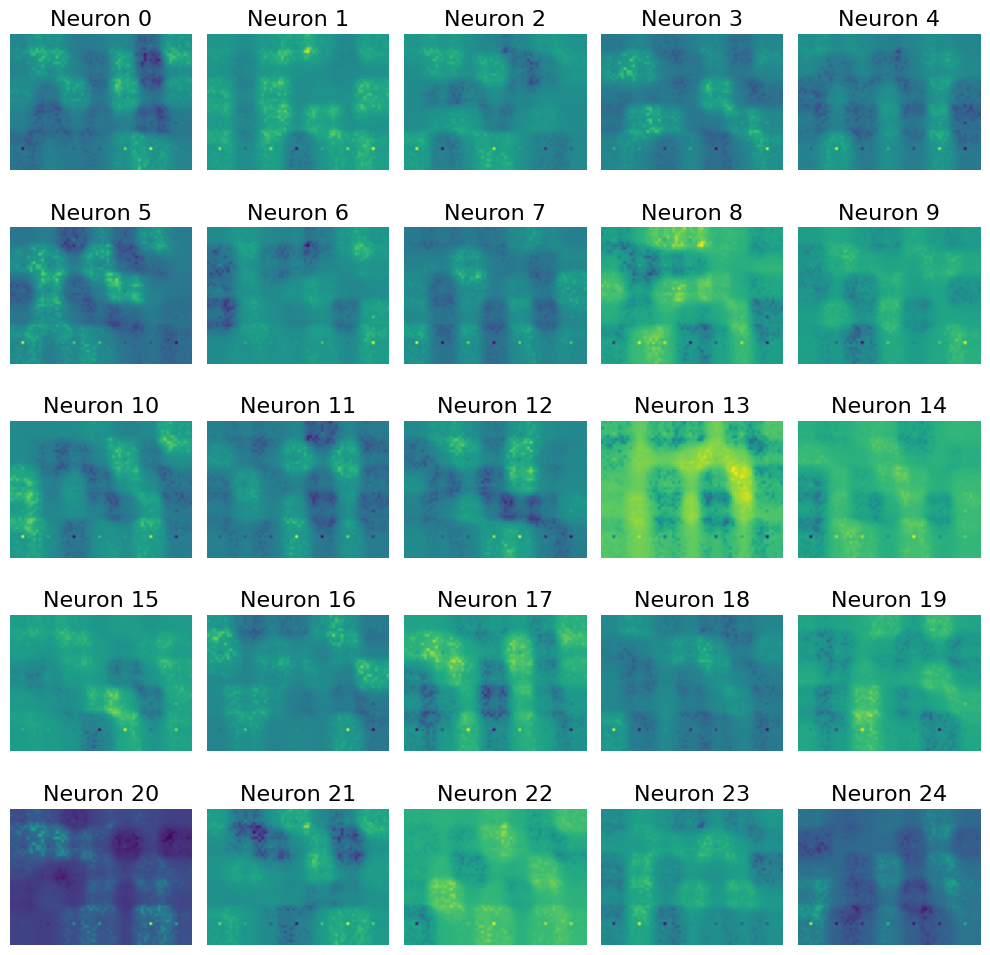

In [59]:
#examine topo organization for last layer
gpt_dict = torch.load("./tau_50.0.pt", map_location=torch.device('cpu'))
out_num, inp_num = topo_nanogpt.transformer.h.mlp.c_fc.weight.shape
print(f'inp num is {inp_num}, and out num is {out_num}')
cortical_sheet = get_cortical_sheet_linear(
    layer=topo_nanogpt.transformer.h.mlp.c_fc
).cpu().detach()

# Set up the 3x3 grid for subplots
fig, axes = plt.subplots(5, 5, figsize=(10, 10))

for idx, ax in enumerate(axes.flat):
    ax.imshow(cortical_sheet[:, :, idx])
    ax.set_title(f"Neuron {idx}", fontsize= 16)
    ax.axis("off")  # Optional: turn off the axis for cleaner visualization
    # plt.colorbar(ax.imshow(cortical_sheet[:, :, idx], cmap="RdBu"), ax=ax, orientation='vertical')

plt.tight_layout()
plt.show()


In [ ]:
#how to probe for interp?
